In [1]:
import torch
import torchaudio
from torchaudio.pipelines import TACOTRON2_WAVERNN_PHONE_LJSPEECH
import IPython
import matplotlib.pyplot as plt


torch.random.manual_seed(0)
device = "cuda" if torch.cuda.is_available() else "cpu"

print(torch.__version__)
print(torchaudio.__version__)
print(device)

import time


2.1.2+cu121
2.1.2+cu121
cuda


In [2]:
text = ''' a result of the country's policy arrangements and decadelong preparations, stand out brightly against the bleak scenario of rising hunger and malnutrition worldwide, food policy experts said.'''
 

In [4]:
start = time.time()
bundle = torchaudio.pipelines.TACOTRON2_WAVERNN_PHONE_LJSPEECH

processor = bundle.get_text_processor()
tacotron2 = bundle.get_tacotron2().to(device)
vocoder = bundle.get_vocoder().to(device)

text = ''' a result of the country's policy arrangements and decadelong preparations, stand out brightly against the bleak scenario of rising hunger and malnutrition worldwide, food policy experts said.'''
 

with torch.inference_mode():
    processed, lengths = processor(text)
    print(processed,lengths)
    processed = processed.to(device)
    lengths = lengths.to(device)
    spec, spec_lengths, _ = tacotron2.infer(processed, lengths)
    #waveforms, lengths = vocoder(spec, spec_lengths)
    
print('总耗时:{}s'.format(round(time.time()-start,3)))


/root/miniconda3/envs/python39/lib/python3.9/site-packages/torch/nn/modules/transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


tensor([[11, 20, 11, 78, 55, 94, 20, 65, 81, 11, 20, 91, 11, 39, 20, 11, 64, 20,
         67, 81, 78, 59, 94, 11, 77, 12, 65, 20, 79, 59, 11, 44, 48, 67, 63, 66,
         20, 67, 81, 79, 11, 16, 67, 38, 11, 38, 40, 64, 16, 38, 20, 65, 24, 68,
         11, 77, 78, 40, 77, 44, 48, 80, 20, 67, 94,  6, 11, 79, 81, 16, 67, 38,
         11, 28, 81, 11, 36, 78, 32, 81, 65, 59, 11, 20, 53, 40, 67, 79, 81, 11,
         39, 20, 11, 36, 65, 59, 64, 11, 79, 55, 67, 40, 78, 59, 69, 11, 20, 91,
         11, 78, 32, 94, 55, 68, 11, 54, 20, 68, 53, 44, 11, 16, 67, 38, 11, 66,
         16, 65, 67, 87, 81, 78, 55, 80, 20, 67, 11, 92, 44, 65, 38, 92, 32, 38,
          6, 11, 52, 87, 38, 11, 77, 12, 65, 20, 79, 59, 11, 40, 64, 79, 77, 44,
         81, 79, 11, 79, 40, 38,  7]]) tensor([169], dtype=torch.int32)
总耗时:2.136s


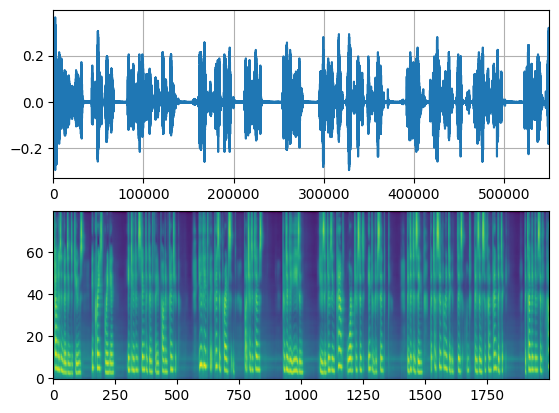

In [22]:
def plot(waveforms, spec, sample_rate):
    waveforms = waveforms.cpu().detach()
    fig, [ax1, ax2] = plt.subplots(2, 1)
    ax1.plot(waveforms[0])
    ax1.set_xlim(0, waveforms.size(-1))
    ax1.grid(True)
    ax2.imshow(spec[0].cpu().detach(), origin="lower", aspect="auto")
    return IPython.display.Audio(waveforms[0:1], rate=sample_rate)


plot(waveforms, spec, vocoder.sample_rate)

In [5]:
start = time.time()

# Workaround to load model mapped on GPU
# https://stackoverflow.com/a/61840832
waveglow = torch.hub.load(
    "NVIDIA/DeepLearningExamples:torchhub",
    "nvidia_waveglow",
    model_math="fp32",
    pretrained=False,
)
checkpoint = torch.hub.load_state_dict_from_url(
    "https://api.ngc.nvidia.com/v2/models/nvidia/waveglowpyt_fp32/versions/1/files/nvidia_waveglowpyt_fp32_20190306.pth",  # noqa: E501
    progress=False,
    map_location=device,
)
state_dict = {key.replace("module.", ""): value for key, value in checkpoint["state_dict"].items()}

waveglow.load_state_dict(state_dict)
waveglow = waveglow.remove_weightnorm(waveglow)
waveglow = waveglow.to(device)
waveglow.eval()

with torch.no_grad():
    waveforms = waveglow.infer(spec)
    
print('总耗时:{}s'.format(round(time.time()-start,3)))

Using cache found in /root/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub


总耗时:8.721s


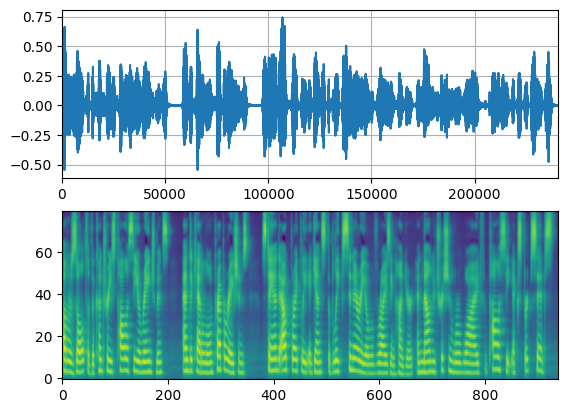

In [7]:
def plot(waveforms, spec, sample_rate):
    waveforms = waveforms.cpu().detach()
    fig, [ax1, ax2] = plt.subplots(2, 1)
    ax1.plot(waveforms[0])
    ax1.set_xlim(0, waveforms.size(-1))
    ax1.grid(True)
    ax2.imshow(spec[0].cpu().detach(), origin="lower", aspect="auto")
    return IPython.display.Audio(waveforms[0:1], rate=sample_rate)


#plot(waveforms, spec, vocoder.sample_rate)
plot(waveforms, spec, 22050)